## **Cell Nuclei Segmentation by An Hoang** ##
<br>

The purpose of this dataset is to segment cell nucleis given 670 stain images and corresponding training masks. Hurdles with this messy dataset includes varying sizes (both image size and cell nuclei sizes), quality (different contrast and histogram distributions), and some number of non-separated training masks.

Both Mask R-CNN and Unet architectures are apropos for this segmentation task. Mask R-CNN is available through a common Matterport distribution, however, customization of its architecture is limited. On the other hand, Unet has been shown to be extremely powerful as a one-shot segmentation algorithm via kaggle's carvanna car segmentation competition. Due to its customizability, the encoder portion of Unet can be replaced with state-of-the-art networks like ResNet for better segmentation, thus the decoder portion can make use of transfer learning (especially for this limited dataset). Additionally, Unet forms the RPN segment of Mask R-CNN, so understanding Unet's optimization aids in optimizing future work on Mask R-CNN.

The strategy to my approach begins with a baseline Unet model following the prescribed architecture in the original [paper](https://arxiv.org/pdf/1505.04597.pdf). Modifications include reduction in filters (primarily because there is insufficient data to train a large network with a huge number of parameters, but also due to computing memory and speed constraints), and the use of 'same' padding instead of no-padding originally in the paper.

Images will be converted to grayscale using the gleam algorithm (due to its [robustness with image classification](https://tdlc.ucsd.edu/SV2013/Kanan_Cottrell_PLOS_Color_2012.pdf)), then cropped to 256x256 pixels. Some images will be randomly sampled once or twice (with corresponding merged masks), depending on its original dimensions (more details below). After creating a base model, I will compare cross-validated results with various image augmentation techniques to increase training data and create a more robust network. I will also introduce the dice cost function to aid in weighing correct mask predictions. Additionally, I will implement an extra binary boundary mask layer as target prediction to help the network focus more on precisely segmenting the boundaries.

In [1]:
import imagehandler
from imagehandler import visualize
import augmentdata
from basicunet import BasicUnet
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


#### Data Distribution ####
<br>
Taking a look at our image data, even though the majority have 256 as the predominant pixel size in the width and height dimension, there are some which exceed that. Looking at the width/height ratio shows us that our training dataset has images that are either square, or long in the vertical direction. Instead of indiscriminantly resizing everything to a consistent dimension, I've chosen to first randomly sample non-square images based on the following rule. If one dimension is longer than the other by no more than 30%, we will randomly sample a square along the length of the longer dimension. If one dimension is longer than the other by MORE than 30%, we will take two square samples at opposite ends of the image, which guarantees that no more than ~70% of the areas of these two new images will overlap. Masks are sampled in accordance with images.

/home/geryon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


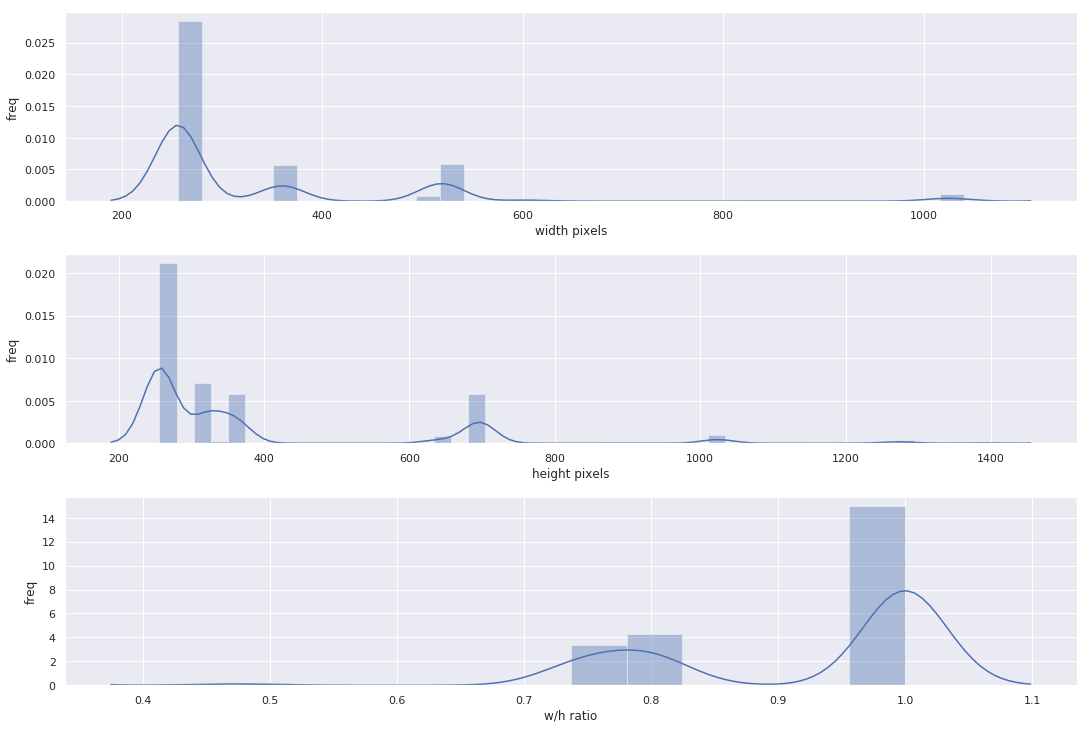

In [2]:
image_class = imagehandler.NucleiImages()
image_class.image_statistics();

In [ ]:
# Lets process our data and save to pickle
image_class.process_save_data()

#### Base Model ####
<br>
We begin with a base unet model consisting of a decoder portion with blocks doubling in filter stacks: 8, 16, 32, 64, 128. The output at the end of these downblocks are concatenated (just before maxpooling, which will yield the best results, according to research) across to the mirroring decoder network. We use a simple binary cross-entropy cost function to predict our binary mask (background or cell nuclei/foreground). The metric we use to measure the model is the one kaggle suggests (which is common in most segmentation tasks), the area of intersection over the union of the masks (IoU). This particular IoU score is calculated by first setting a threshold of 0.5, 0.6, ..., 1.0. These thresholds represent the proportion of correctly overlapping pixels over the union of pixels. If the prediction exceeds this threshold, we can count it towards a correct prediction. Across these thresholds, we will take a mean and yield a single average IoU score.

With earlystopping, our 10% validation split yields a .3090 IoU. We can better this score by first incorporating the [dice similarity coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
to weigh the area of overlap more.

In [4]:
# Get the paths to our pickled files and load up the data
train_features_path = image_class.settings.train_features_pkl
train_targets_path = image_class.settings.train_targets_pkl
train_features = image_class.load_pkl_data(train_features_path)
train_targets = image_class.load_pkl_data(train_targets_path)

# Turn 2D into 3D array (1 channel)
X_train = list(map(lambda n: np.expand_dims(n, axis = -1), train_features))
Y_train = list(map(lambda n: np.expand_dims(n, axis = -1), train_targets))
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Ensure masks are binary
Y_train = Y_train > 0
Y_train = Y_train.astype('int8')

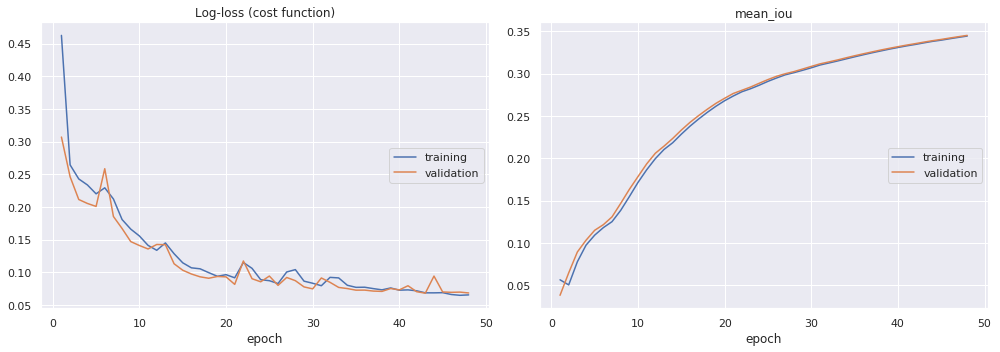

696/696 [==============================] - 3s 5ms/step - loss: 0.0653 - mean_iou: 0.3442 - val_loss: 0.0683 - val_mean_iou: 0.3450
Epoch 00048: early stopping


In [5]:
unet_model = BasicUnet((256, 256, 1))
unet_model.train(X_train, Y_train)

#### Dice Coefficient ####
<br>
Training this model a few times, one can see that the training is unstable and slow to converge. A major problem with using just binary cross-entropy to maximize the mean_iou is that each pixel calculation is weighed the same, but there are many more negative examples (background pixels) than there are positive examples (pixels that are cell nuclei). This encourages the algorithm to guess the negative class more often, not necessarily learning key segmentation features.

There are two approaches to solve this imbalance, the first is to set class weights for the negative and positive class, giving more weight to the lesser class (positive here), so that our algorithm is discouraged from guessing just the dominant class pixel. The second approach is to add to the cost function a Dice Coefficient. The Dice Coefficient was used in other kaggle competitions such as carvanna's car segmentation. It is a measure of similarity between sets. Here it is the percentage of overlap between predicted and truth mask. It is also possible to use Jaccard/IoU metric directly to weigh mask predictions more. These two metrics are related.

We can see immediate improvements in terms of faster convergence in earlier epochs, as well has a much better mean IoU as we expected (because we are adding an explicit cost for correctly predicting the masked area).

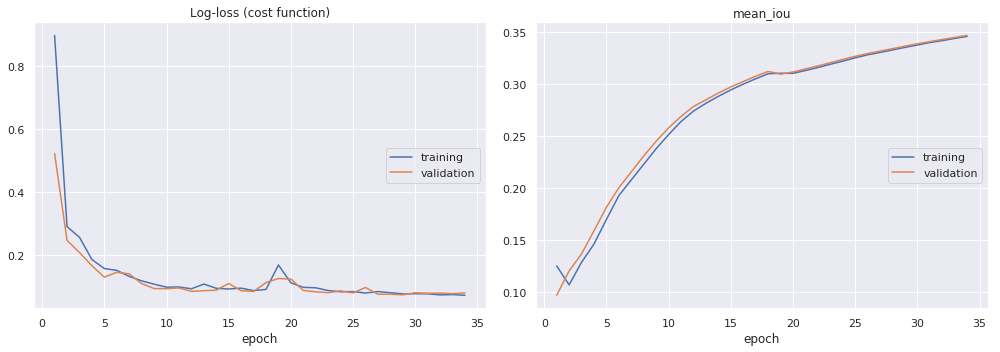

696/696 [==============================] - 3s 5ms/step - loss: 0.0710 - mean_iou: 0.3461 - val_loss: 0.0783 - val_mean_iou: 0.3471
Epoch 00034: early stopping


In [6]:
unet_bce_dice = BasicUnet((256, 256, 1), class_weight = [0.10, 0.90], cost='dice_bce')
unet_bce_dice.train(X_train, Y_train)

#### Class Weights, Cost Function Weights, and Contour Mask ####
<br>
Before, we didn't discuss what is the appropriate class_weight. A good rule of thumb is to pick a class weight for the binary cross-entropy (BCE) cost function that balances classes when you multiply the coefficients with the total number of respective class in the training set. Because BCE weighs each class the same, we can choose to proportionally weight the cost to offset for the class imbalance.

Secondly, because we now have BCE and also the Dice Coefficient in our cost function, we can choose to weigh these terms differently. A good practice to do this is cross-validating a set of weights that optimizes the mean_iou. Here, I choose weights that sum up to 1. The rationale behind this is if you set very large weights (for example, like 20*Dice Coefficient), or extremely small weights, your cost function will blow up or be very near zero, which will cause problems in backpropagation.

Finally, by visually inspecting the model predictions against ground truth, we can see where the model does perform well. It is at the borders (as usually all segmentation tasks have a hard time with). In order to address this, we add an additional mask in our prediction channel. This particular mask is a binary mask that draws the outline of our predicted nuclei cells. This is an explicit way to tell our algorithm that we want to weigh border predictions highly. The border mask is calculated using opencv's contour function. Our network output is modified so that there are two filters at the end of the network to predict our two mask layers. Now that we have an additional layer, we can also custom set weights for either our background/foreground mask predictions, as well as our contour mask predictions and test which set of weighs optimize mean IoU.

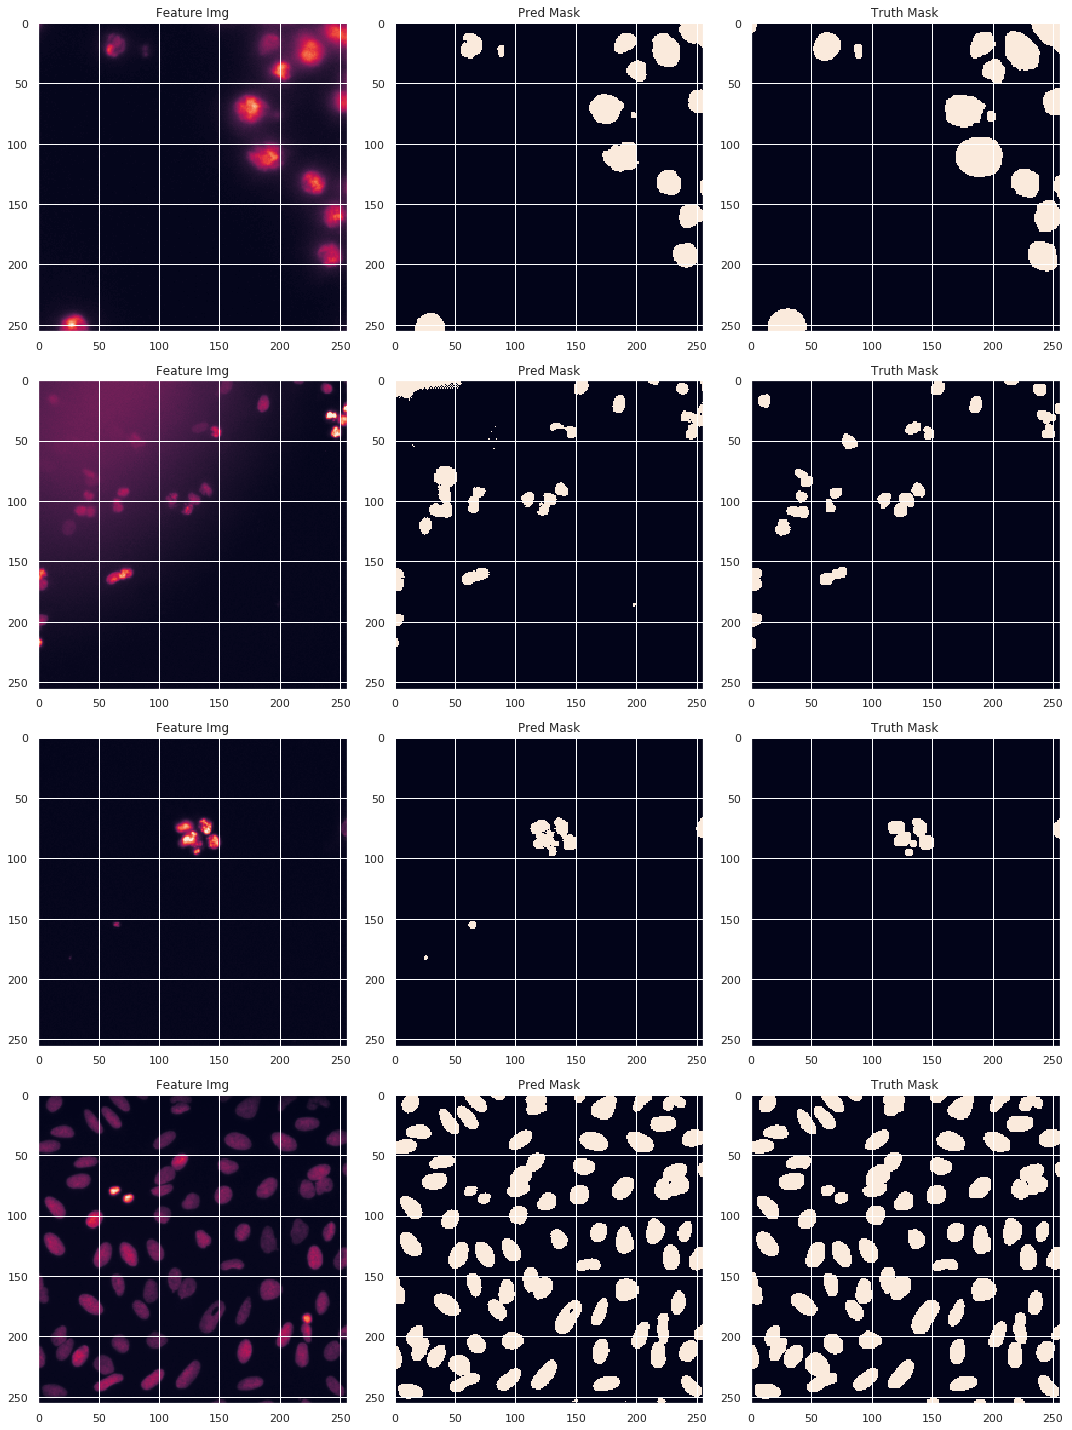

In [7]:
# We are going to visualize feature images, predicted mask, and output mask
img_indices = [0,1,3, 200]
preds = unet_bce_dice.predict(X_train)
inspect_model = visualize(img_indices, X_train, Y_train, preds)
plt.show();

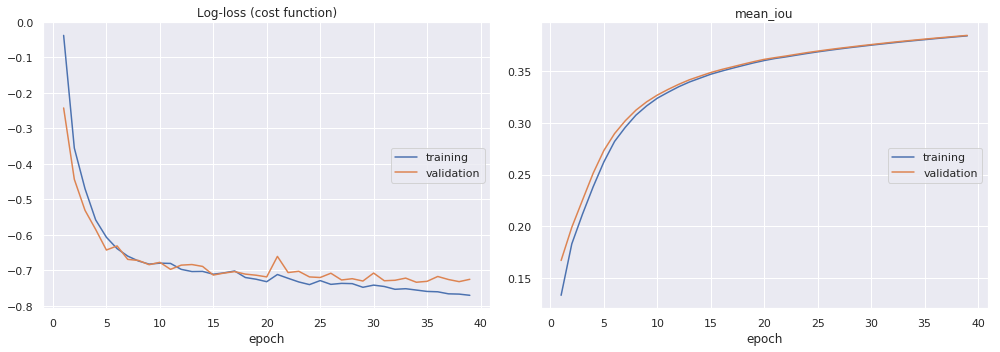

696/696 [==============================] - 4s 6ms/step - loss: -0.7704 - mean_iou: 0.3843 - val_loss: -0.7253 - val_mean_iou: 0.3847
Epoch 00039: early stopping


In [9]:
Y_train = imagehandler.stack_contour(train_targets)
unet_contour = BasicUnet((256, 256, 1), n_classes = 2, class_weight = [0.10, 0.90], cost='weighted_bce_dice', contour_weight = .2)
unet_contour.train(X_train, Y_train)

#### Data Augmentation ####
<br>
Lastly, knowing that this dataset is very limited, we can choose sensible augmentation methods that will help in this task: translation, zoom, skew, reflection, and shear. Strictly, we ought to use cross-validation to ensure that these transformations do really aid with improving our mean IoU, but we know apriori that these transforms will help due to domain knowledge from other segmentation applications. Here, we will use Keras's test-time ImageDataGenerator in order to produce data on the go as we train (only for the training data, the test data is untouched).

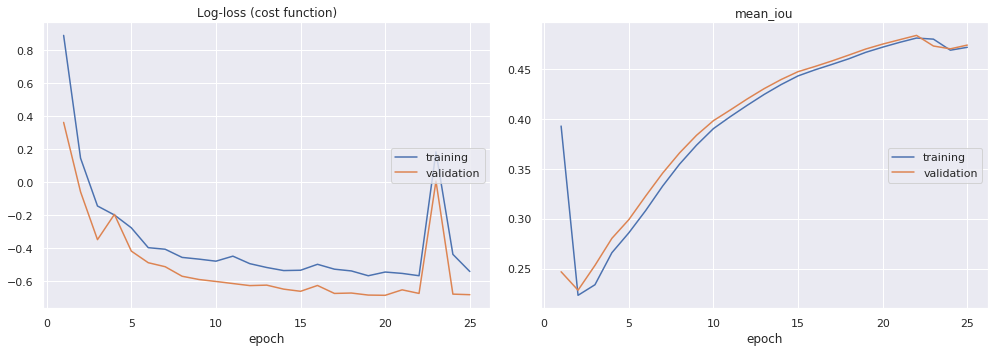

44/43 [==============================] - 8s 193ms/step - loss: -0.5415 - mean_iou: 0.4717 - val_loss: -0.6810 - val_mean_iou: 0.4739
Epoch 00025: early stopping


In [10]:
unet_augment = BasicUnet((256, 256, 1), n_classes = 2, class_weight = [0.10, 0.90], cost='weighted_bce_dice', contour_weight = .2)
unet_augment.train_augment(X_train, Y_train)

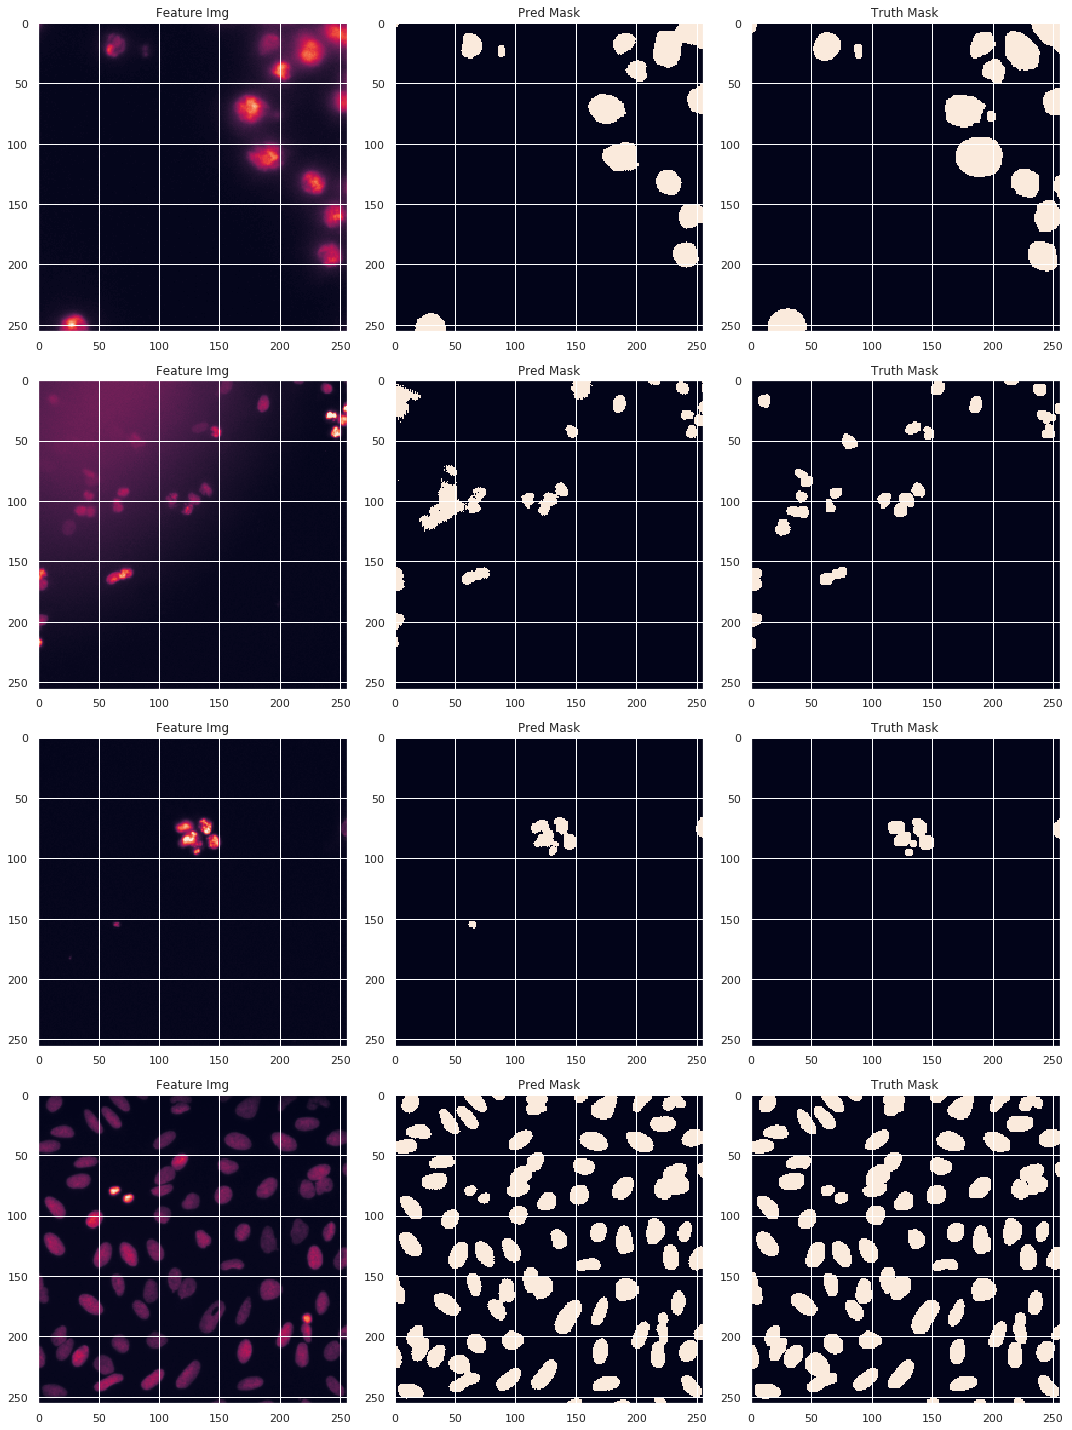

In [11]:
# Last visualizations for our final model
img_indices = [0,1,3, 200]
preds = unet_augment.predict(X_train)
inspect_model = visualize(img_indices, X_train, Y_train, preds)
plt.show();

#### Conclusions ####
<br>
There are many more improvements that can be made to the model, but due to lack of time, I was unable to implement and test. Firstly, we can improve border predictions more by testing either random walker segmentation or watershed segementation. Watershed method will create another binary mask, which we can use to explicitly help the network learn how to segment touching cells. The mask would be border regions between touching cells. This should, [according to research](https://arxiv.org/pdf/1611.08303.pdf), improve our segmentation results. We also see that there are holes within mask predictions, so using post-processing methods that close holes will clearly also improve IoU.

Additionally, since this is a sample limited dataset, it can greatly benefit from transfer learning. The magic of Unet is its versatility. We can replace the encoder network with deeper and more robust networks like ResNet 34 or 50, etc., then rebuild the decoder portion to correspond with chosen network (and incorporate crosslinks). Then we can use pre-trained weighs, and then train our augmented dataset on that backbone. Additionally, we can also implement state of the art improvements on ResNet, train it ourselves on ImageNet data from scratch, then train this particular tasks on the weights of that network.

As we've seen, small incremental improvements brought our validated mean_iou from ~.30 to above ~.5, so with additional improvements, and a deeper, more state-of-the-art encoder-decoder network, we can expect a better performance from our metric. I was time limited in this project, so instead of choosing to use deeper models from the get-go, I stayed with a smaller model to be able to iterate through various improvements quicker.